<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

## Подготовка

In [3]:
df = pd.read_csv('C:/Users/Гоша/Downloads/taxi.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [6]:
df.duplicated().sum()

0

In [7]:
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

Данные находятся в идеальном состоянии, поэтому никакой обработки не требуют.

In [8]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [9]:
df = df.set_index('datetime')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


На данном этапе мы изучили данные, распознали даты и сформировали новые индексы.

## Анализ

Перейдем к ресеплингу данных.

Посмотрим как изменялось количество заказов по месяцам.

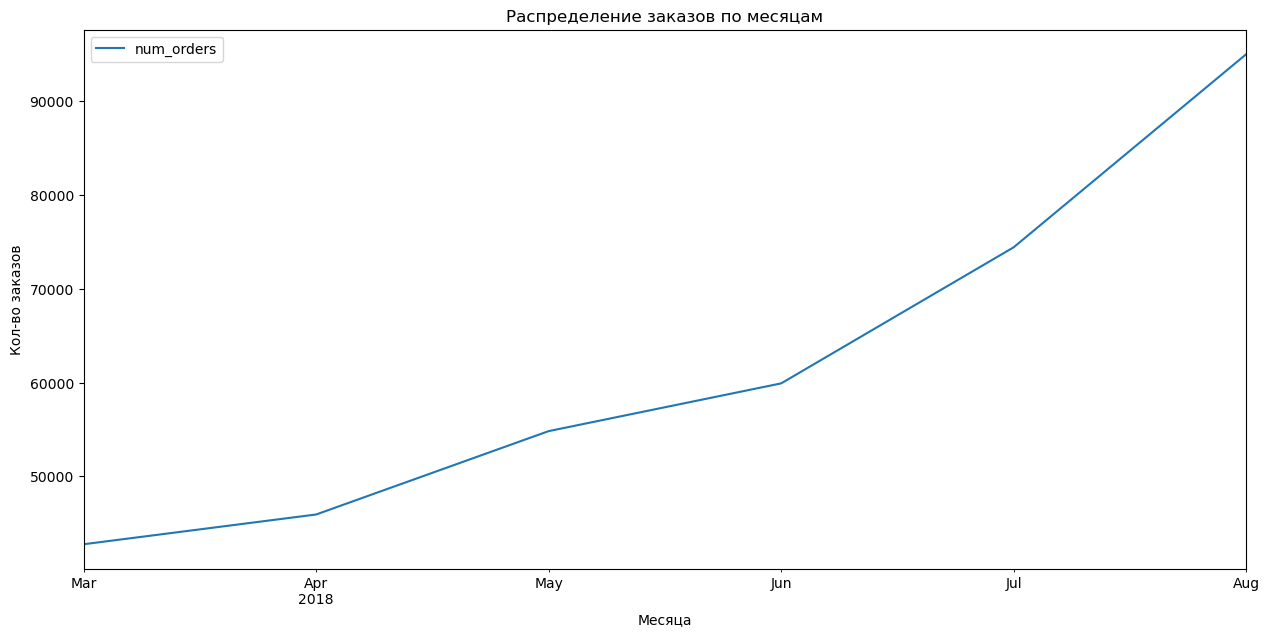

In [11]:
month = df.resample('1M').sum()
month.plot(figsize=(15,7))
plt.title('Распределение заказов по месяцам')
plt.xlabel('Месяца')
plt.ylabel('Кол-во заказов');

In [12]:
hour = df.resample('1H').sum()
hour['rolling_mean']=hour.shift().rolling(50).mean()

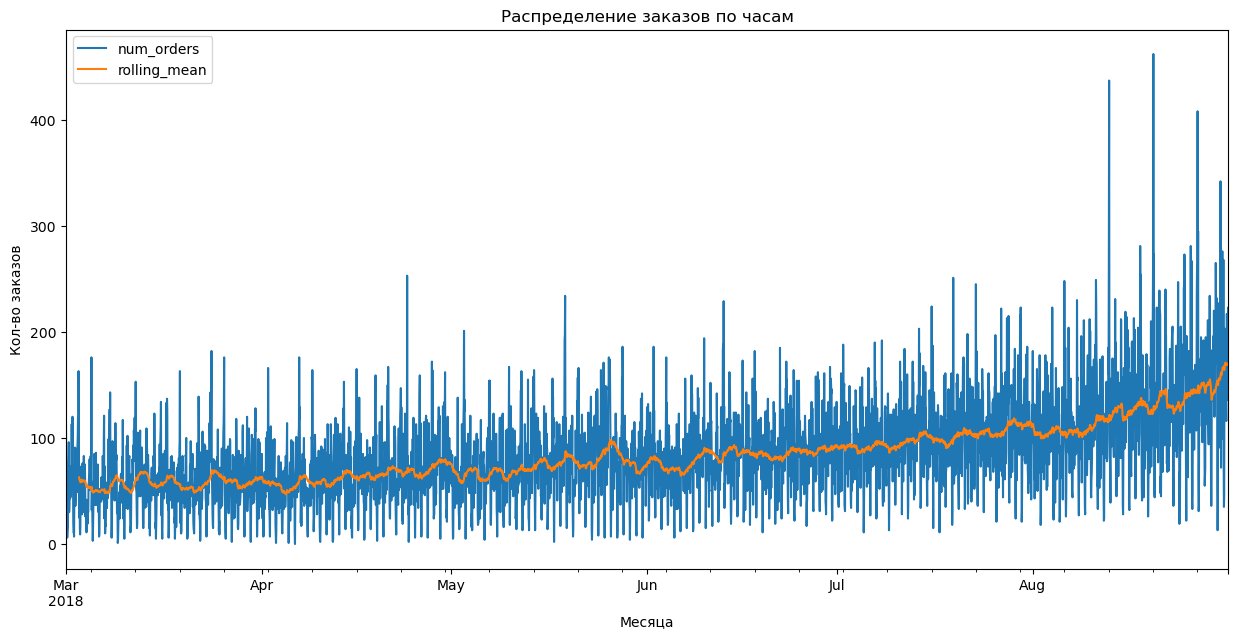

In [13]:
hour.plot(figsize=(15,7))
plt.title('Распределение заказов по часам')
plt.xlabel('Месяца')
plt.ylabel('Кол-во заказов');

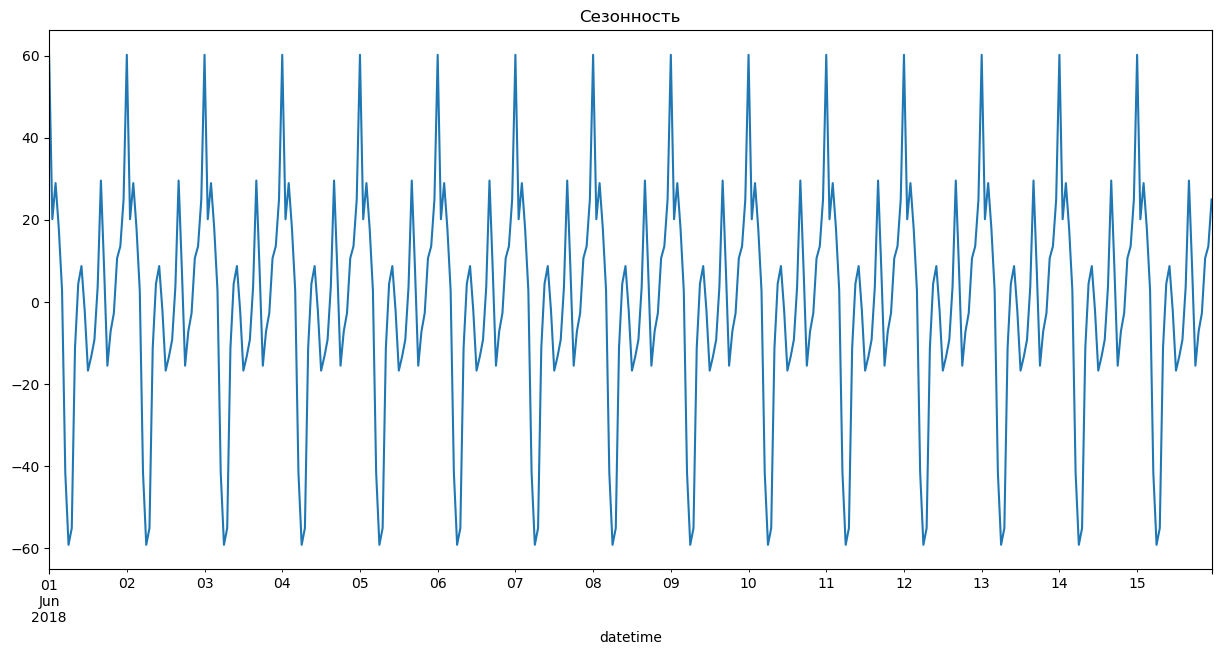

In [14]:
df = df.resample('1H').sum()
decomposed = seasonal_decompose(df)
decomposed.seasonal['2018-06-01':'2018-06-15'].plot(ax=plt.gca(), figsize=(15,7))
plt.title('Сезонность');

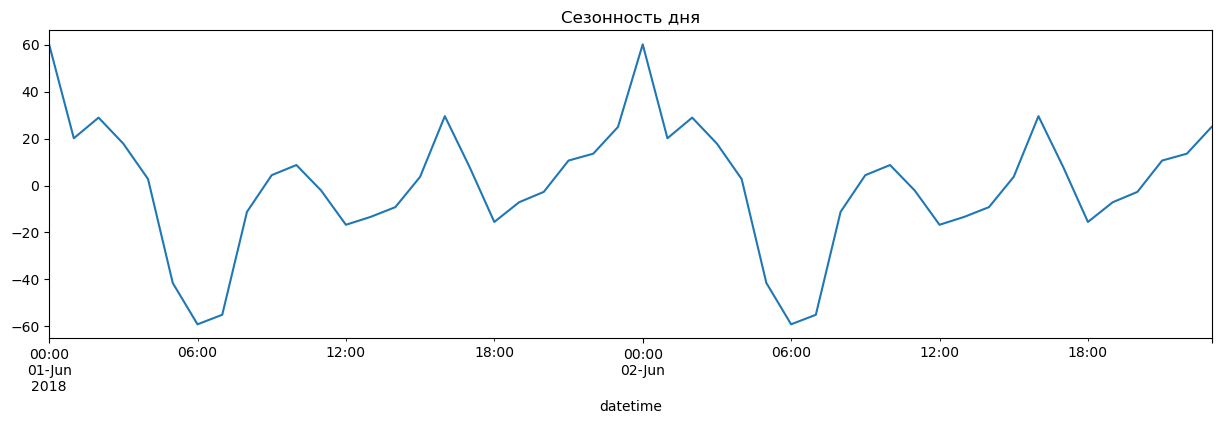

In [15]:
decomposed.seasonal['2018-06-01':'2018-06-02'].plot(ax=plt.gca(), figsize=(15,4))
plt.title('Сезонность дня');

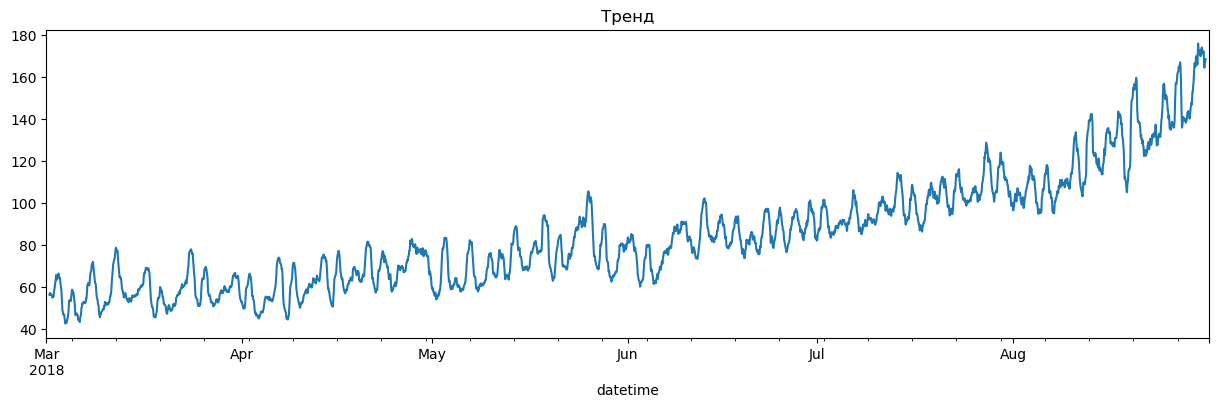

In [16]:
decomposed.trend.plot(ax=plt.gca(), title='Тренд', figsize=(15,4));

### Выводы:

Скользящее стреднее имеет тенденцию к росту, следовательно ряд нестационарен.

- График довольно волатильный, но исходя из тредна, можно сделать вывод, что количесво заказов за рассмотренные месяца, а именно с марта по август, имеет тенденцию к росту. Следовательно можно сделать вывод, что в летнее время года такси от аэропорта пользуется большим спросом. В течении суток пик спроса на такси приходится в полночь, максимальная точка спада приходится на 6 утра. 
- Поддобные колебания внутри дня могут быть связаны c тем что общественный транспорт перестает работать.

## Обучение

Создадим признаки и обучим модель.

In [17]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data.dropna()

In [18]:
data = make_features(df, 24, 100)

In [19]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [20]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3884, 29)
(432, 29)
(3884,)
(432,)


In [21]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
   
RMSE_score = make_scorer(RMSE, greater_is_better=False)

Так как мы работаем с временным рядом, нельзя применять кросс-валидацию в привычном виде для подбора гиперпараметров моделей с помощью `GridSearchCV`. Поэтому применим функцию `TimeSeriesSplit`.

In [22]:
splits = 5

In [23]:
my_cv = TimeSeriesSplit(n_splits=splits).split(features_train)

In [24]:
regression = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
regression_cv_score = pd.Series(cross_val_score(regression,features_train,
                                                target_train,
                                                scoring=RMSE_score,
                                                cv=my_cv)
                               ).mean()*(-1)
print('Качество модели линейной регрессии на кросс-валидации:', regression_cv_score)

Качество модели линейной регрессии на кросс-валидации: 28.373815399708082


In [25]:
state = 12345

In [41]:
LGBMR = LGBMRegressor(random_state = state) 
hyperparams = [{'depth' : [3, 5],
                'learning_rate':[0.03, 0.01],
                'verbose' : [10],}]
my_cv=TimeSeriesSplit(n_splits=splits).split(features_train)
clf = GridSearchCV(LGBMR, hyperparams, cv=my_cv, scoring=RMSE_score)
clf.fit(features_train, target_train)
print(clf.best_params_)
print(clf.best_score_ * (-1))

[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.005250
[LightGBM] [Debug] init for col-wise cost 0.000006 seconds, init for row-wise cost 0.000216 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2655
[LightGBM] [Info] Number of data points in the train set: 649, number of used features: 27
[LightGBM] [Info] Start training from score 57.543914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tre

Исходя из проведенного анализа качество LGBMRegressor на кросс-валидации равно 26.1, в то время как качество модели линейной регрессии на кросс-валидации равно 28.4.
Исходя из этих данных можно сделать вывод, что наилучшая модель является линейная регрессия.

## Тестирование

In [30]:
predictions_test =regression.predict(features_test)
print('RMSE модели дерева решений:', mean_squared_error(target_test, predictions_test)**0.5)

RMSE модели дерева решений: 47.10347629417676


Пропишем функцию для построения сравнительных графиков целевой признак - предсказание модели:

In [41]:
def graphic(predictions):
    model_data = pd.DataFrame({"target":target_test, "predict":predictions})
    model_data.plot(figsize=(18, 6), xlabel='Дни', ylabel='Кол-во заказов')
    model_data['2018-08-22':'2018-08-24'].plot(figsize=(18, 6), xlabel='Часы', ylabel='Кол-во заказов')

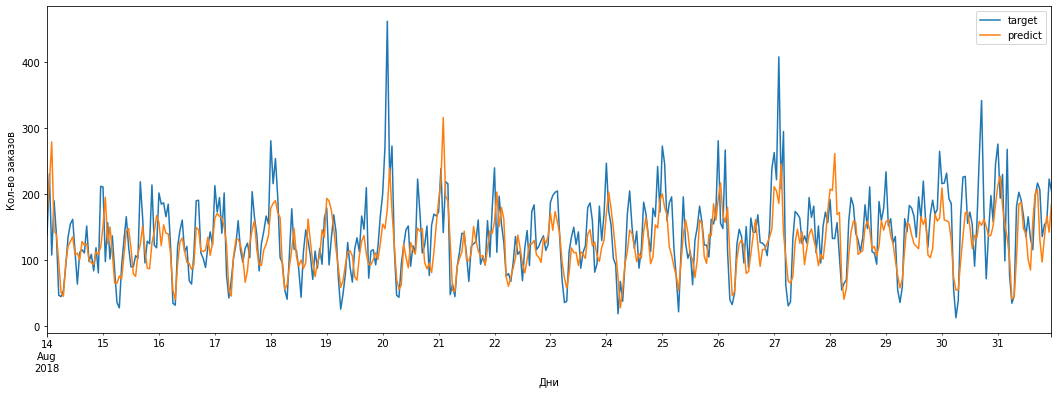

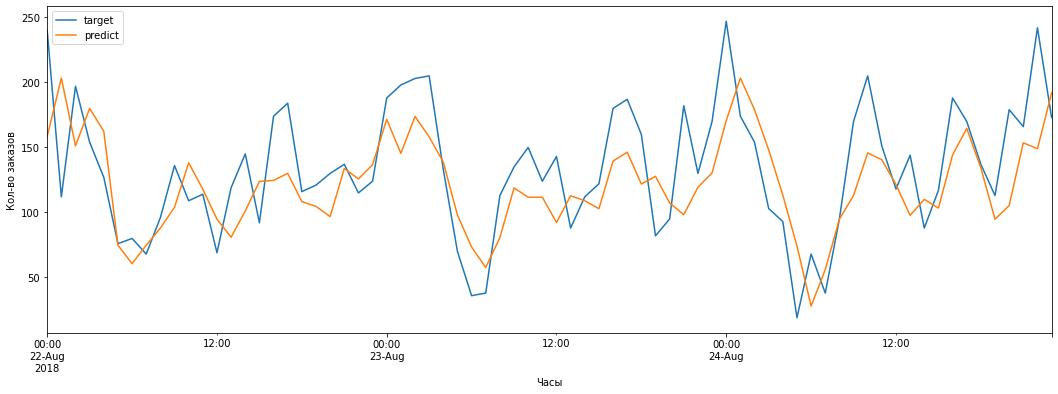

In [42]:
graphic(regression_predictions)

Исходя из граффиков выше, можно сделать вывод, что предсказние модели незначительно отличается от правильных ответов. Предсказание дает небольшие сбои только в местах повышенного спроса на такси.

Проверим модель на адекватность с помощью DummyRegressor.

In [46]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(features_train, target_train)
dummy_pred = dummy.predict(features_test)
dummy_mse = mean_squared_error(target_test, dummy_pred)
dummy_rmse = np.sqrt(dummy_mse)
print(dummy_rmse)

84.80942472748956


### Вывод
В проекте были проанализированы временные ряды заказа такси к аэропорту и создана модель для прогназирования нагрузки на следущий час. Были рассмотрены дые модели LinearRegression и LGBMRegressor. 

Мы провели анализ данных моделей на кросс-валидацию и вяснили, что наилучшей моделей будет LinearRegression со значением 28.4. 

При тестовой выборке выбранная нами модель показала результат по метрики RMSE равный 47.1. 

В результате проверки модели на адекватность, мы выяснили, что выбранная нами модель показала результат лучше, чем константная. 